# CSCA-5622: Project Final
## Credit Card Fraud Detection

### Import Libraries and functions needed for the project

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt 
%matplotlib inline 

### Class to import and process the data sets

In [171]:
# This cell sets up the CCData data set


class CCData:
    """
    Class to import the training data, create features and result components and splits it into training and test sets.
    """
    def __init__(self, transactions: str, identities: str):
        
        # read in the transaction and identity data files
        tx_df = pd.read_csv(transactions)
        print(f'number of transactions: {len(tx_df)}')
        self.id_df = pd.read_csv(identities)   # keeping a referece to the identity data set for independent evaluation
        print(f'number of transactions with identity data: {len(self.id_df)}')
        
        # create dataframes for the features and response variable
        y = tx_df['isFraud'].values.astype('int32')
        X = tx_df.drop('isFraud', axis=1)
        
        # merge the identity attributes with the associated transactions
        X = pd.merge(X, self.id_df, on='TransactionID', how='left')
        
        # set the transaction data set Categorical Features as 'category' data type
        col_filter = ['ProductCD', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']
        col_filter.extend(data.X_train.filter(regex='card[1-6]').columns.to_list())
        col_filter.extend(data.X_test.filter(regex='M[1-9]').columns.to_list())
        col_filter.extend(data.X_train.filter(regex='addr[1-2]').columns.to_list())
        col_filter.extend(data.X_train.filter(regex='id_(1[2-9]|2[0-9]|3[0-8])').columns.to_list())   # columns id_12 thru id_38
        X[col_filter] = X[col_filter].astype('category')
        
        # split the data for training and test data sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # reindex the dataframes to match response arrays
        self.X_train.reset_index(drop=True, inplace=True)
        self.X_train.reset_index(drop=True, inplace=True)

# create the data object from the training transaction and identity files provided by IEEE-CIS
data = CCData('./train_transaction.csv', './train_identity.csv')

number of transactions: 590540
number of transactions with identity data: 144233


## Exploratory Data Analysis (EDA)

### Describe the Data

In [172]:
print(data.X_train.head())
print(data.X_train.info())

# get column counts with incomplete data
print('\n\nFeatures with missing values count:')
data.X_train.isna().sum()

   TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        2992307         174911          59.000         W   4988  334.0   
1        3178582        4301977          23.378         C   3867  296.0   
2        3247168        6229929          35.950         W  12577  268.0   
3        3005516         497176         100.000         R   6019  583.0   
4        3034538        1124702          75.000         H  16075  514.0   

   card3       card4  card5   card6  ...                    id_31 id_32  \
0  150.0        visa  226.0   debit  ...                      NaN   NaN   
1  185.0        visa  226.0  credit  ...              chrome 63.0   NaN   
2  150.0        visa  166.0   debit  ...                      NaN   NaN   
3  150.0        visa  226.0  credit  ...              chrome 62.0  24.0   
4  150.0  mastercard  102.0  credit  ...  chrome 62.0 for android  32.0   

       id_33           id_34 id_35 id_36  id_37  id_38  DeviceType  \
0        NaN             NaN

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
                   ...  
id_36             359671
id_37             359671
id_38             359671
DeviceType        359813
DeviceInfo        377531
Length: 433, dtype: int64

### Determine the percentage of missing data from the features

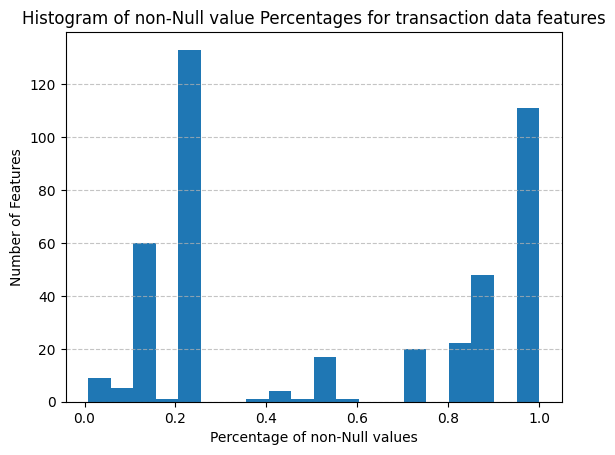

In [173]:
num_transactions = len(data.X_train)
counts = data.X_train.count()   # counts of non-emtpy values
percentage = counts / num_transactions   # percentage of non-empty values over number of transactions

# create a summary dataframe to evaluate empty/non-empty percentages by feature
summary = pd.DataFrame([counts, percentage], index=['count', 'percentage'])

plt.figure()
plt.hist(summary.loc['percentage'], bins=20)
plt.grid(axis='y', linestyle='--', alpha=0.75)
plt.title("Histogram of non-Null value Percentages for transaction data features")
plt.xlabel("Percentage of non-Null values")
plt.ylabel("Number of Features")
plt.show()

### Let's evaluate the features that contain less than 70% of non-empty values

It looks like almost half of the features have a large number of missing values. So, let's try to identify which features to see if we can remove some to improve the data set.

In [201]:
# get feature list
print(summary.head())

# threshold
threshold = 0.7

# get the percentage row and list the indexes that have a value less than the defined threshold
row = summary.loc['percentage']
match = row < threshold
feature_list = row.index
eval_features = feature_list[match].tolist()
print(eval_features)

            TransactionID  TransactionDT  TransactionAmt  ProductCD     card1  \
count            472432.0       472432.0        472432.0   472432.0  472432.0   
percentage            1.0            1.0             1.0        1.0       1.0   

                    card2          card3          card4          card5  \
count       465254.000000  471179.000000  471169.000000  469033.000000   
percentage       0.984806       0.997348       0.997327       0.992805   

                    card6  ...          id_31         id_32         id_33  \
count       471174.000000  ...  112195.000000  61921.000000  58533.000000   
percentage       0.997337  ...       0.237484      0.131069      0.123897   

                   id_34          id_35          id_36          id_37  \
count       62121.000000  112761.000000  112761.000000  112761.000000   
percentage      0.131492       0.238682       0.238682       0.238682   

                    id_38     DeviceType    DeviceInfo  
count       112761.00000

### Identity data evaluation 
All of the columns in the identity data set fall into this list. This makes sense, since there are only 144,233 transactions with identities out of 590,540 total transactions (~24%). As such, removing all these feature columns will remove all additional transaction identity features. 

Let's review the transaction training data fraud determination and see the relation to having or not having identity data

In [202]:
# let's determine a column that has the most complete features in the identity data set
print(data.id_df.isna().sum())

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22            139064
id_23            139064
id_24            139486
id_25            139101
id_26            139070
id_27            139064
id_28              3255
id_29              3255
id_30             66668
id_31              3951
id_32             66647
id_33             70944
id_34             66428
id_35              3248
id_36              3248
id_37              3248
id_38              3248
DeviceType         3423
DeviceInfo        25567
dtype: int64


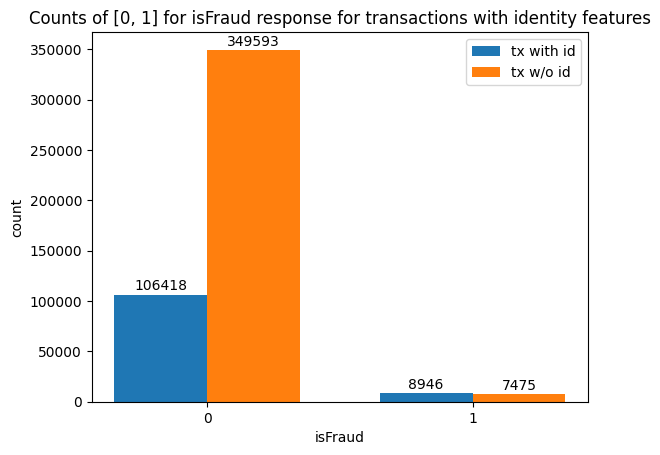

In [203]:
# since id_0 is not missing any attributes, let's plot the fraud outcomes just for the transactions with identity data
tx_indexes = data.X_train.index[data.X_train['id_01'].notna()]

# get the fraud results for the transactions with identity values
counts = np.bincount(data.y_train[tx_indexes])

# fraud outcomes for transactions without identity data
tx_indexes_wo = data.X_train.index[data.X_train['id_01'].isna()]

# get counts
counts_wo = np.bincount(data.y_train[tx_indexes_wo])

# bar plot
labels = ['0', '1']
x = np.arange(len(labels))
bar_width = 0.35

fig, ax = plt.subplots()
id_bar = ax.bar(x - bar_width/2, counts, bar_width, label='tx with id')
no_id_bar = ax.bar(x + bar_width/2, counts_wo, bar_width, label='tx w/o id')

ax.set_xticks(x)
ax.set_xlabel('isFraud')
ax.set_ylabel('count')
ax.set_title('Counts of [0, 1] for isFraud response for transactions with identity features')
ax.legend()

# add count to each bar
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 1), textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(id_bar)
autolabel(no_id_bar)

plt.show()


### Based on the plot results, the number of fraud cases are relatively split between transactions with and without identity data

Let's review what features, outside of the identity data, are missing values and to what percent. 

   TransactionDT  TransactionAmt ProductCD  card1  card2  card3       card4  \
0         174911          59.000         W   4988  334.0  150.0        visa   
1        4301977          23.378         C   3867  296.0  185.0        visa   
2        6229929          35.950         W  12577  268.0  150.0        visa   
3         497176         100.000         R   6019  583.0  150.0        visa   
4        1124702          75.000         H  16075  514.0  150.0  mastercard   

   card5   card6  addr1  ... V330  V331  V332 V333 V334  V335  V336  V337  \
0  226.0   debit  315.0  ...  NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
1  226.0  credit    NaN  ...  NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
2  166.0   debit  476.0  ...  NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN   
3  226.0  credit  126.0  ...  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   
4  102.0  credit  325.0  ...  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   

   V338  V339  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN 

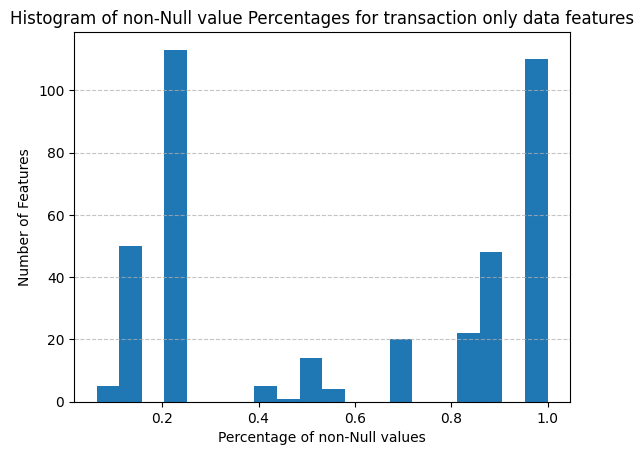

In [204]:
# get columns associated with the identity data set
id_columns = data.id_df.columns.tolist()

# create a transaction only data set
data_tx_only = data.X_train.drop(id_columns, axis=1)
print(data_tx_only.head())

# now evaluate the percentage of missing data from the remaining features
counts = data_tx_only.count()   # counts of non-emtpy values
percentage = counts / num_transactions   # percentage of non-empty values over number of transactions

# create a summary dataframe to evaluate empty/non-empty percentages by feature
summary2 = pd.DataFrame([counts, percentage], index=['count', 'percentage'])

plt.figure()
plt.hist(summary2.loc['percentage'], bins=20)
plt.grid(axis='y', linestyle='--', alpha=0.75)
plt.title("Histogram of non-Null value Percentages for transaction only data features")
plt.xlabel("Percentage of non-Null values")
plt.ylabel("Number of Features")
plt.show()

Still looks there are a large number of features missing a high percentage of values, even after removing the identity related features. Let's identify the remaining features, other than the identity data related ones, that have values for less than 60% of the transactions

In [207]:
# threshold
threshold = 0.6

# get the percentage row and list the indexes that have a value less than the defined threshold
row = summary.loc['percentage']  # using the summary table from above
match = row < threshold
features = row.index
low_data_features = features[match].tolist()
print(low_data_features)
print(f'removing {len(low_data_features)} features')

['dist1', 'dist2', 'R_emaildomain', 'D2', 'D3', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'M1', 'M2', 'M3', 'M4', 'M5', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V

### Categorical Data Review
Let's look at the categorical data and see if we can identify if any are ordinal

In [212]:
# iterate through data columns that are category
for col in data.X_train.select_dtypes(include='category'):
    categories = data.X_train[col].unique()
    print(f'feature: {col}\n{categories}')

feature: ProductCD
['W', 'C', 'R', 'H', 'S']
Categories (5, object): ['C', 'H', 'R', 'S', 'W']
feature: card1
[4988, 3867, 12577, 6019, 16075, ..., 12706, 17717, 3420, 3812, 12855]
Length: 12804
Categories (13553, int64): [1000, 1001, 1004, 1005, ..., 18391, 18393, 18395, 18396]
feature: card2
[334.0, 296.0, 268.0, 583.0, 514.0, ..., 544.0, 312.0, 447.0, 377.0, 473.0]
Length: 501
Categories (500, float64): [100.0, 101.0, 102.0, 103.0, ..., 597.0, 598.0, 599.0, 600.0]
feature: card3
[150.0, 185.0, 106.0, 131.0, 146.0, ..., 202.0, 193.0, 206.0, 224.0, 125.0]
Length: 107
Categories (114, float64): [100.0, 101.0, 102.0, 105.0, ..., 227.0, 228.0, 229.0, 231.0]
feature: card4
['visa', 'mastercard', 'american express', 'discover', NaN]
Categories (4, object): ['american express', 'discover', 'mastercard', 'visa']
feature: card5
[226.0, 166.0, 102.0, 137.0, 224.0, ..., 120.0, 178.0, 230.0, 234.0, 191.0]
Length: 117
Categories (119, float64): [100.0, 101.0, 102.0, 104.0, ..., 234.0, 235.0, 236.

No obvious ordinal categories, so we will use OneHotEncoder for encoding all categorical features. Let's see how many features have more than 10 categories

In [226]:
# iterate through data columns that are category
for col in data.X_train.select_dtypes(include='category'):
    count = data.X_train[col].nunique()
    # if the number of categories is > 10, then see how many are in the top 10
    if count > 10:
        print(f'feature: {col}:  {count}')
        print(data.X_train[col].value_counts().sort_values(ascending=False).head(20))

feature: card1:  12804
card1
7919     11987
9500     11348
17188     8328
15885     8284
15066     6372
12695     5663
12544     5440
6019      5401
2803      4956
7585      4260
10616     4201
12839     4183
3154      3674
2616      3531
18132     3380
9633      3362
15497     3187
16132     3166
2884      3112
16075     2979
Name: count, dtype: int64
feature: card2:  500
card2
321.0    39258
111.0    36034
555.0    33573
490.0    30587
583.0    17411
170.0    14521
194.0    13608
545.0    13067
360.0    12130
514.0    11583
174.0     9034
512.0     8087
408.0     6390
361.0     6263
100.0     6110
225.0     5953
215.0     5816
399.0     5776
553.0     5203
268.0     5043
Name: count, dtype: int64
feature: card3:  106
card3
150.0    416900
185.0     45176
106.0      1262
146.0      1029
144.0      1016
117.0       762
143.0       729
119.0       609
102.0       362
147.0       312
162.0       276
203.0       208
100.0       174
213.0       166
131.0       143
188.0       139
200.0    

Based on the counts for the categories, the initial pass will be to limit encoding for the top 10. We can evaluate improvements to this later when we do more feature engineering.

## Next steps for EDA

Given the number of features missing values, and the number of transactions that do not have identity related data, let's try three different approaches with the data set to see how each approach affects the training and test accuracy.

### Data Set Approaches:
#### 1. Imputed data for all features
For this data set, use all features, including the identity data, and impute values for the missing data. Use the mean for numerical features and the mode for categorical features.
#### 2. Remove identity features
For this data set, remove the identity features and impute values for the missing data in the remaining features. Use the mean for numerical features and the mode for categorical features.
#### 3. Remove all features missing more than 40% values
For this data set, remove the identity features and any additional features where more than 40% of the transactions are missing values. The  remaining features will have the missing values imputed, using the mean for numerical features and the mode for categorical features.

## Data Processing

Since all three approaches include imputing missing data, we can perform the data processing to the base training data, then drop the features identified from the previous data exploration steps.

### Steps:
#### 1. Encode Categorical Features


In [ ]:
# 